In [ ]:
!pip install sklearn_crfsuite

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import nltk
import os
import re
import string
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sklearn_crfsuite import CRF, metrics
from sklearn import preprocessing
from sklearn.metrics import classification_report
from collections import defaultdict

In [2]:
Drugs = ['ARTHROTEC', 'CAMBIA', 'CATAFLAM', 'DICLOFENAC-POTASSIUM', 'DICLOFENAC-SODIUM',
         'FLECTOR', 'LIPITOR', 'PENNSAID', 'SOLARAZE', 'VOLTAREN', 'VOLTAREN-XR', 'ZIPSOR']

CLR = ['indigo', 'plum', 'darkmagenta', 'pink', 'darkred', 'lightsalmon']

# EDA

Take a look at patient 1 who takes Arthrotec.

In [47]:
# all detected entities
pd.read_csv("E:\TM\Final\CADEC\original\ARTHROTEC.1.ann", sep='\t', header=None)

,0,1,2
0,T1,ADR 9 19,bit drowsy
1,#1,AnnotatorNotes T1,Drowsy
2,T2,ADR 29 50,little blurred vision
3,#2,AnnotatorNotes T2,Blurred Vision
4,T3,Drug 93 102,Arthrotec
5,T5,Disease 179 188,arthritis
6,T6,Symptom 260 265,agony
7,T4,ADR 62 78,gastric problems
8,T7,Symptom 412 417,pains
9,T8,ADR 437 453,feel a bit weird


In [48]:
# terms tagged with ADR that are mapped to MedDRA database
pd.read_csv("E:\TM\Final\CADEC\meddra\ARTHROTEC.1.ann", sep='\t', header=None)

,0,1,2
0,TT1,10013649 9 19,bit drowsy
1,TT2,10005886 29 50,little blurred vision
2,TT4,10056819 62 78,gastric problems
3,TT8,10025482 437 453,feel a bit weird


In [49]:
# Non-drug terms mapped to SCT database
pd.read_csv("E:\TM\Final\CADEC\sct\ARTHROTEC.1.ann", sep='\t', header=None)

,0,1,2
0,TT1,271782001 | Drowsy | 9 19,bit drowsy
1,TT2,246636008 | Blurred vision - hazy | 29 50,little blurred vision
2,TT4,162076009 | Excessive upper gastrointestinal g...,gastric problems
3,TT3,3384011000036100 | Arthrotec | 93 102,Arthrotec
4,TT5,3723001 | Arthritis | 179 188,arthritis
5,TT6,102498003 | Agony | or 76948002|Severe pain| 2...,agony
6,TT7,22253000 | Pain | 412 417,pains
7,TT8,367391008 | Malaise | 437 453,feel a bit weird


## Types of Name Entities

Not every report has name entities labelled. For those that do, there are $6$ types of name entities: **ADR, AnnotatorNotes, Disease, Drug, Finding, Symptom**. All drugs but FLECTOR have some words in the reports tagged as ADR. The distributions of entity tags are rather different across drugs, except for VOLTAREN and VOLTAREN-XR.

In [3]:
num_Reports = dict()    # dictionary: drug --> the number of reports 
print('Number of Reports for each drug: \n')
for drug in Drugs:
    Files = Path('E:/TM/Final/CADEC/original').glob(drug+'*.ann')
    num_Reports[drug] = sum([1 for file in Files])
    print(drug, '-->', num_Reports[drug])

Number of Reports for each drug: 

ARTHROTEC --> 145
CAMBIA --> 4
CATAFLAM --> 10
DICLOFENAC-POTASSIUM --> 3
DICLOFENAC-SODIUM --> 7
FLECTOR --> 1
LIPITOR --> 1000
PENNSAID --> 4
SOLARAZE --> 3
VOLTAREN --> 68
VOLTAREN-XR --> 22
ZIPSOR --> 5


In [4]:
Tags = dict()  # a dictionary: drug --> a list of tags
Empty_tags = dict()   # a dictionary: drug --> the number of reports without any name entities labelled

for drug in Drugs:
    print(drug, ':')
    Files = Path('E:/TM/Final/CADEC/original').glob(drug+'*.ann')
    lst = list()
    count = 0
    for file in Files:
        try:
            data = pd.read_csv(file, sep='\t', header=None)
            lst.extend(data.iloc[:,1].tolist())
        except:
            st = os.stat(file)
            print(st.st_size, 'bytes <--', file)
            count += 1
    print('\n')
    Tags[drug] = lst
    Empty_tags[drug] = count

ARTHROTEC :


CAMBIA :
0 bytes <-- E:\TM\Final\CADEC\original\CAMBIA.1.ann


CATAFLAM :


DICLOFENAC-POTASSIUM :


DICLOFENAC-SODIUM :


FLECTOR :


LIPITOR :
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.197.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.243.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.28.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.285.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.299.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.308.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.313.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.383.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.4.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.40.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.41.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.416.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.437.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.438.ann
0 bytes <-- E:\TM\Final\CADEC\original\LIPITOR.444.ann
0 bytes <-- E:\TM\Fin

In [46]:
# an example of reports without any name entities labelled
fhand = open('E:/TM/Final/CADEC/text/LIPITOR.197.txt')
print(fhand.read())

None that I am aware of.
This drug has been extremely helpful to me so far.
I've been on it over a year now.
It significantly lowered my cholesterol within 3 months, which shocked me.
To be fair, I am on 3 other medications, so if I was to have any side effects I wouldn't know what to attribute it to anyway.
But so far so excellent.



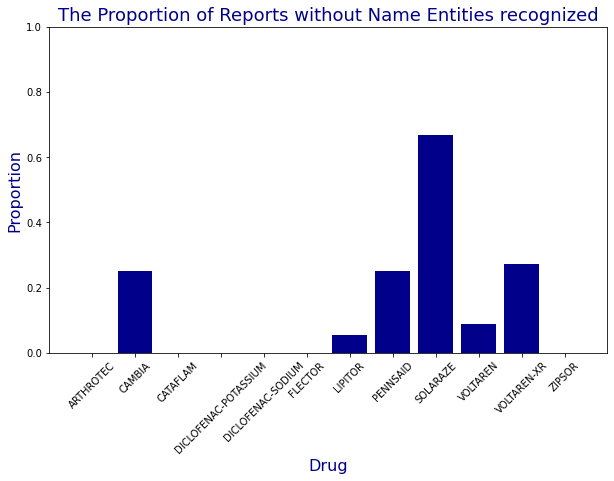

In [5]:
# the proportion of reports without any entities labelled
plt.figure(figsize=(10,6))
plt.bar(Drugs, [Empty_tags[drug]/num_Reports[drug] for drug in Drugs], color='darkblue')
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.xlabel('Drug', fontsize=16, color='darkblue')
plt.ylabel('Proportion', fontsize=16, color='darkblue')
plt.title('The Proportion of Reports without Name Entities recognized', fontsize=18, color='darkblue')
plt.show()

In [6]:
# types of name entities for each drug
for drug in Drugs:
    lst = [re.findall('(\S+)\s', ele)[0] for ele in Tags[drug]]  # extract the 1st part of a tag
    lst = list(set(lst))
    lst.sort()
    print(drug, '-->', lst, '\n')

ARTHROTEC --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

CAMBIA --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding'] 

CATAFLAM --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

DICLOFENAC-POTASSIUM --> ['ADR', 'AnnotatorNotes', 'Symptom'] 

DICLOFENAC-SODIUM --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Symptom'] 

FLECTOR --> ['Disease', 'Drug', 'Symptom'] 

LIPITOR --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

PENNSAID --> ['ADR', 'AnnotatorNotes', 'Drug', 'Finding', 'Symptom'] 

SOLARAZE --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug'] 

VOLTAREN --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

VOLTAREN-XR --> ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'] 

ZIPSOR --> ['ADR', 'Disease', 'Drug', 'Finding', 'Symptom'] 



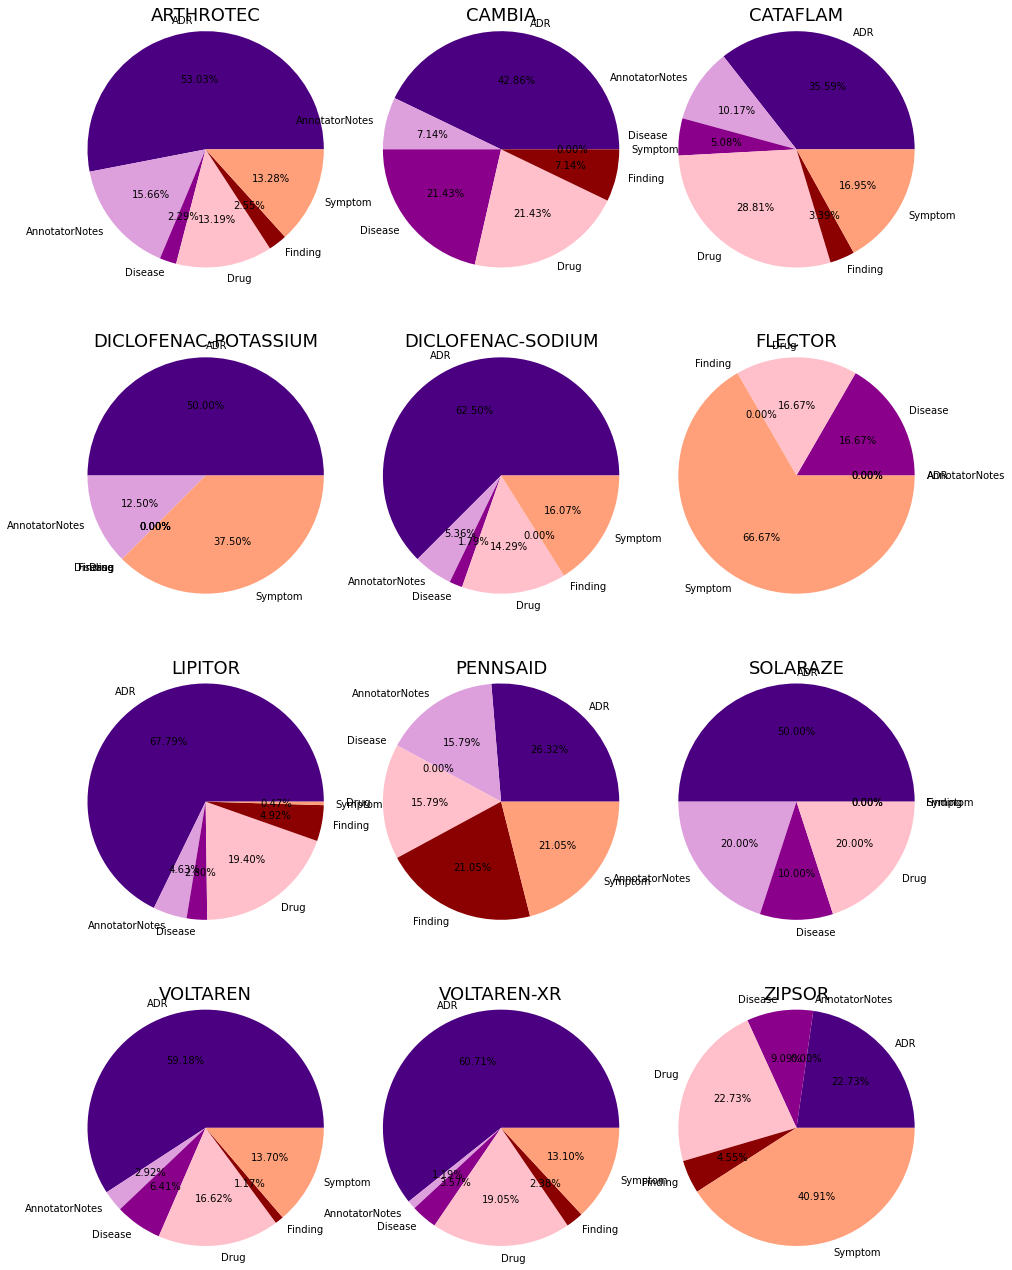

In [62]:
row,col,r = 4,3,1.2

def count_tags(raw_tags):
    Count_NE = dict()
    for entity in ['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom']:
        Count_NE[entity] = sum([1 for ele in raw_tags if ele.startswith(entity)])
    return Count_NE

pic,axes = plt.subplots(row,col, figsize=(15,23))
for k, drug in enumerate(Drugs):
    data =count_tags(Tags[drug])
    i = int(k/col)
    j = k - col*i
    axes[i,j].pie(list(data.values()), labels=tuple(data.keys()), autopct='%1.2f%%', colors=CLR, radius=r)
    axes[i,j].set_title(drug, fontsize=18)
plt.show()

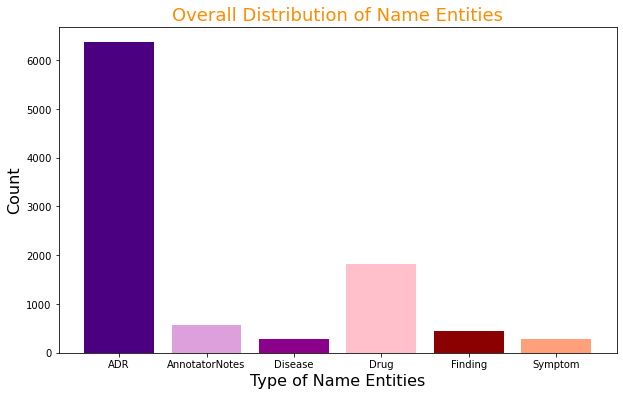

In [63]:
# overall distribution of name entities regardless of drug
plt.figure(figsize=(10,6))
plt.bar(['ADR', 'AnnotatorNotes', 'Disease', 'Drug', 'Finding', 'Symptom'],
        count_tags([ele for sublist in Tags.values() for ele in sublist]).values(),
        color = CLR)
plt.xlabel('Type of Name Entities', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Overall Distribution of Name Entities', fontsize=18, color='darkorange')
plt.show()

# Adverse Drug Effect (ADR tags)

In [31]:
# the number of raw tags for each drug
for drug in Drugs:
    print(drug, ":", len(Tags[drug]))

ARTHROTEC : 1137
CAMBIA : 14
CATAFLAM : 59
DICLOFENAC-POTASSIUM : 8
DICLOFENAC-SODIUM : 56
FLECTOR : 6
LIPITOR : 8012
PENNSAID : 19
SOLARAZE : 10
VOLTAREN : 343
VOLTAREN-XR : 84
ZIPSOR : 22


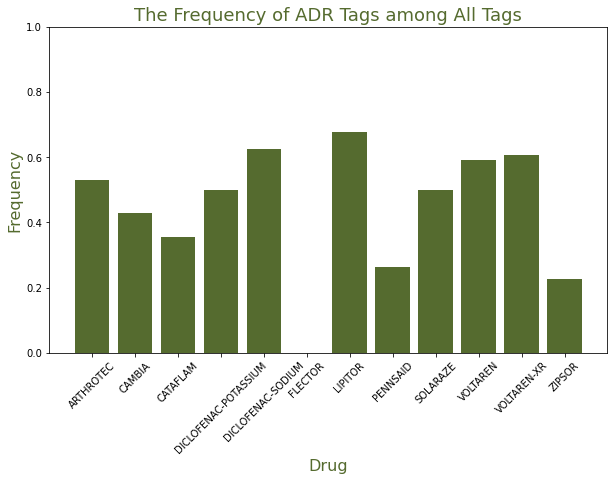

In [32]:
# frequency of ADR tags for each drug
def freq_ADR(tags):
    return sum([tag.startswith('ADR') for tag in tags]) / len(tags)

plt.figure(figsize=(10,6))
plt.bar(Drugs, [freq_ADR(Tags[drug]) for drug in Drugs], color='darkolivegreen')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.xlabel('Drug', fontsize=16, color='darkolivegreen')
plt.ylabel('Frequency', fontsize=16, color='darkolivegreen')
plt.title('The Frequency of ADR Tags among All Tags', fontsize=18, color='darkolivegreen')
plt.show()

# Pre-processing

## Representation: (token, POS, OBI)

Represent each report as a list of (token, POS, OBI).

In [3]:
Reports = Path('E:/TM/Final/CADEC/text').glob('*.txt')
DATA = list()
for report in Reports:
    #raw_text = open(report).read().replace(',',', ').replace('.','. ').replace('&','& ').replace('!','! ')   
    #raw_text = raw_text.replace("'"," '").replace('(',' (').replace(')',') ').replace('/',' /').replace('-',' -')
    raw_text = open(report).read()  # each report = a string
    word_pos = nltk.pos_tag(raw_text.split())  # a list of (word, POS)
    # OBI tagging: a list of OBI labels
    try:
        TAB = pd.read_csv('E:/TM/Final/CADEC/original/'+report.name.replace('.txt','.ann'), sep='\t', header=None)
        for tag, terms in zip(TAB.iloc[:,1], TAB.iloc[:,2]):
            name_entity = re.findall('(\S+)\s', tag)[0]+'\t'      # identify the name entitiy
            labels = 'B-'+name_entity + (' I-'+name_entity)*(len(terms.split())-1)    # BI tags for the name entity
            raw_text = raw_text.replace(terms, labels)
        OBI = list()
        for ele in raw_text.split():
            if ele.startswith('B-') or ele.startswith('I-'):
                OBI.append(ele.rstrip(string.punctuation))
            else:
                OBI.append('O')
    except:
        OBI = ['O']*len(raw_text.split())
    # report = a list of (word, POS, OBI)
    DATA.append([(a,b,c) for (a,b),c in zip(word_pos, OBI)])

In [4]:
print('There are', len(DATA), 'reports in total. One instance: \n')
# an example of report representation
DATA[99]

There are 1250 reports in total. One instance: 



[('Disorentatation,trouble', 'JJ', 'B-ADR'),
 ('brathing,', 'NN', 'O'),
 ('extreme', 'NN', 'I-ADR'),
 ('hot,', 'NN', 'O'),
 ('redness', 'NN', 'B-ADR'),
 ('and', 'CC', 'I-ADR'),
 ('swelling,', 'NN', 'O'),
 ('itching,', 'NN', 'B-ADR'),
 ('later', 'RBR', 'I-ADR'),
 ('abominal', 'JJ', 'I-ADR'),
 ('cramps.', 'NN', 'O'),
 ('All', 'PDT', 'B-ADR'),
 ('this', 'DT', 'O'),
 ('came', 'VBD', 'O'),
 ('all', 'DT', 'B-ADR'),
 ('sudden', 'JJ', 'I-ADR'),
 ('in', 'IN', 'O'),
 ('couple', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('minutes.', 'NN', 'O'),
 ('I', 'PRP', 'O'),
 ('had', 'VBD', 'O'),
 ('been', 'VBN', 'O'),
 ('taking', 'VBG', 'O'),
 ('arthrotec', 'JJ', 'O'),
 ('before', 'IN', 'O'),
 ('for', 'IN', 'O'),
 ('my', 'PRP$', 'O'),
 ('knee', 'NN', 'O'),
 ('pain', 'NN', 'O'),
 ('and', 'CC', 'B-Drug'),
 ('it', 'PRP', 'O'),
 ('helped', 'VBD', 'O'),
 ('me', 'PRP', 'O'),
 ('a', 'DT', 'B-Symptom'),
 ('lot.', 'NN', 'I-Symptom'),
 ('I', 'PRP', 'O'),
 ('only', 'RB', 'O'),
 ('had', 'VBD', 'O'),
 ('10-12', 'JJ', 'O'),
 ('p

## Split: Training Set, Development Set, Test Set

Split dataset into training set, development set, and test set by $0.6:0.2:0.2$.

In [5]:
random.seed(888)

TRAIN = random.sample(DATA, int(len(DATA)*0.6))
DEV = random.sample([report for report in DATA if not report in TRAIN], int(len(DATA)*0.2))
TEST = [report for report in DATA if not (report in TRAIN or report in DEV)]

print('There are', len(TRAIN), 'reports in the training set,', 
      len(DEV), 'in the development set, and', len(TEST), 'in the test set.')

There are 750 reports in the training set, 250 in the development set, and 250 in the test set.


## Features Extraction

**Features:**
1. **Word Identity**: lowercased form
2. **Word Suffix**: the last two and three characters
3. **Word Shape**: whether a word is a digit, is uppercased, or starts with an uppercase character
4. **POS Tag**: noun, verb, adjective, e.t.c
5. **BOS**: whether a word is the beginning of sentence; if not, extract features of the previous word
6. **EOS**: whether a word is the end of sentence; if not, extract features of the following word

In [28]:
# extract features and labels
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {'bias': 1.0,
                'word.lower()': word.lower(),      # word identity
                'word[-3:]': word[-3:],            # word suffix
                'word[-2:]': word[-2:],
                'word.isupper()': word.isupper(),  # word shape
                'word.istitle()': word.istitle(),
                'word.isdigit()': word.isdigit(),
                'postag': postag,                  # POS tag  
                'postag[:2]': postag[:2],
               } 
    if i > 0:
        features['BOS'] = False
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({'-1:word.lower()': word1.lower(),          # features of the previous word
                         '-1:word.istitle()': word1.istitle(),
                         '-1:word.isupper()': word1.isupper(),
                         '-1:postag': postag1,
                         '-1:postag[:2]': postag1[:2],
                        })
    else:
        features['BOS'] = True                    # BOS
        features.update({'-1:word.lower()': 0,
                         '-1:word.istitle()': 0,
                         '-1:word.isupper()': 0,
                         '-1:postag': 0,
                         '-1:postag[:2]': 0,
                        })
        
    if i < len(sent)-1:
        features['EOS'] = False
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({'+1:word.lower()': word1.lower(),       # features of the following word 
                         '+1:word.istitle()': word1.istitle(),
                         '+1:word.isupper()': word1.isupper(),
                         '+1:postag': postag1,
                         '+1:postag[:2]': postag1[:2],
                       })
    else:
        features['EOS'] = True                   # EOS
        features.update({'+1:word.lower()': 0,
                         '+1:word.istitle()': 0,
                         '+1:word.isupper()': 0,
                         '+1:postag': 0,
                         '+1:postag[:2]': 0,
                       })
    
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [29]:
def setup(data_sents):
    return [sent2features(s) for s in data_sents], [sent2labels(s) for s in data_sents]

# set up datasets
X_train,y_train = setup(TRAIN)
X_test, y_test  = setup(TEST)
X_dev,  y_dev   = setup(DEV)

# Conditional Random Field



## Baseline

Generate **transition features** that associate all of the possible label pairs and **iterate 100 times at most** by the **L-BFGS algorithm of Gradient Descent** with Elastic-Net regularization to fit model parameters; in specific, **L1-regularization** is controlled by $c_1 = 0.1$ and **L2-regularization** by $c_2 = 0.1$.

In [30]:
# training
baseline = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
baseline.fit(X_train, y_train)

# evaluate
print('Overall Accuracy on Test Set:', baseline.score(X_test, y_test), '\n')
labels = list(baseline.classes_)
labels.remove('O')
sorted_labels = sorted(labels, key = lambda name:(name[1:], name[0]))
print(metrics.flat_classification_report(y_test, baseline.predict(X_test), labels=sorted_labels, digits=4))

Overall Accuracy on Test Set: 0.828126431516262 



d:\python\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-ADR', 'I-ADR', 'B-AnnotatorNotes', 'B-Disease', 'I-Disease', 'B-Drug', 'I-Drug', 'B-Finding', 'I-Finding', 'B-Symptom', 'I-Symptom'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

           B-ADR     0.3443    0.1512    0.2101      1111
           I-ADR     0.4160    0.2006    0.2706      1790
B-AnnotatorNotes     0.0000    0.0000    0.0000         0
       B-Disease     0.3333    0.0172    0.0328        58
       I-Disease     0.2500    0.0244    0.0444        41
          B-Drug     0.2892    0.0650    0.1062       369
          I-Drug     0.0000    0.0000    0.0000        35
       B-Finding     0.1538    0.0247    0.0426        81
       I-Finding     0.0909    0.0118    0.0208        85
       B-Symptom     0.0000    0.0000    0.0000        50
       I-Symptom     0.0000    0.0000    0.0000        45

       micro avg     0.3787    0.1517    0.2166      3665
       macro avg     0.1707    0.0450    0.0661      3665
    weighted avg     0.3502    0.1517    0.2090      3665



## Hyperparameter Optimization on Development Set

Execute a $10 \times 10$ rough grid search on $(c_1, c_2) \in [0, 1] \times [0, 1]$ and use the development set for evaluation.

In [56]:

#from sklearn.metrics import make_scorer

In [59]:
a,b, c,d, k = 0,1, 0,1, 10

def score(c1, c2, algorithm, transitions):
    if algorithm=='lbfgs':
        crf = CRF(algorithm='lbfgs', c1=c1, c2=c2, max_iterations=100, all_possible_transitions=transitions)
    if algorithm=='l2sgd':
        crf = CRF(algorithm='l2sgd', c2=c2, max_iterations=100, all_possible_transitions=transitions)
    crf.fit(X_train, y_train)
    return metrics.flat_f1_score(y_dev, crf.predict(X_dev), average='weighted', labels=labels)

LB = dict()
for c1 in np.linspace(a,b,k):
    lst = list()
    for c2 in np.linspace(a,b,k):
        panda = np.mean([score(c1, c2, 'lbfgs', True) for run in range(3)])
        grizzly=np.mean([score(c1, c2, 'lbfgs', False) for run in range(3)])
        lst.append((panda,grizzly))
    LB['c1 = '+str(round(c1,2))] = lst
LB = pd.DataFrame(LB, index=['c2 = '+str(round(ele,2)) for ele in np.linspace(a,b,k)])

L2 = dict()
for c2 in np.linspace(c,d,k):
    panda = np.mean([score(0, c2, 'l2sgd', True) for run in range(5)])
    grizzly=np.mean([score(0, c2, 'l2sgd', False) for run in range(5)])
    L2['c2 = '+str(round(c2,2))] = (panda, grizzly)
L2 = pd.DataFrame(L2, index=['Transition Features', 'No Transitions'])

In [60]:
LB

,c1 = 0.0,c1 = 0.11,c1 = 0.22,c1 = 0.33,c1 = 0.44,c1 = 0.56,c1 = 0.67,c1 = 0.78,c1 = 0.89,c1 = 1.0
c2 = 0.0,"(0.21116041779467384, 0.2036088036416108)","(0.20330278389265546, 0.20846716471860746)","(0.19710970396791738, 0.19268944416594805)","(0.20481396533000226, 0.20493501147573143)","(0.200304277832461, 0.2034745574354964)","(0.1899985335569929, 0.1997368380821443)","(0.19230328031128707, 0.19155070566836507)","(0.18453090774919464, 0.18252274341126765)","(0.17608565577446114, 0.17481732104542436)","(0.1695700192180193, 0.16549841162766565)"
c2 = 0.11,"(0.2116288651692461, 0.18289780604605074)","(0.19062545602148429, 0.18767051770991597)","(0.19362191082661542, 0.1867752943920412)","(0.194335262376184, 0.189046138645388)","(0.1898874452737578, 0.18757295220061732)","(0.1829168867122761, 0.17589500490167853)","(0.17179542644529935, 0.1804571117727752)","(0.17081586718467676, 0.1723998771441924)","(0.16376039176607898, 0.16968937539598586)","(0.16132479474225617, 0.16663507166724473)"
c2 = 0.22,"(0.19655879626782388, 0.1699896687634426)","(0.18800590728327826, 0.18205619734356004)","(0.18578670704171577, 0.18391488268052236)","(0.18212498031469546, 0.18435673757187962)","(0.17871904325381852, 0.17910451920943857)","(0.17169925137265576, 0.1767899664320147)","(0.17049035950913285, 0.167564407982827)","(0.167402204635431, 0.16771368268151252)","(0.16377205443123838, 0.16684155737176487)","(0.16395144603603282, 0.15524656986242127)"
c2 = 0.33,"(0.19573701523181028, 0.1824959839163277)","(0.1801991949322652, 0.17786864974761188)","(0.1792666487600205, 0.18119242210708966)","(0.18369859324314294, 0.180937804462425)","(0.1756896907175557, 0.17063538215733734)","(0.16755903523252902, 0.17116213088313628)","(0.16875515539979133, 0.16421695012988052)","(0.16546344089653775, 0.16311899973791896)","(0.15934610051417808, 0.15665891839274876)","(0.15160371043776424, 0.15183998075751656)"
c2 = 0.44,"(0.16318030267508588, 0.18763841624916544)","(0.17857890557054668, 0.18334329566028526)","(0.17408831239724806, 0.17116649706217665)","(0.17253653297587448, 0.16460254791162077)","(0.1654349775445703, 0.16338868287111552)","(0.16752198486531103, 0.16981590150902734)","(0.1632878944350428, 0.168858531120063)","(0.16086290835677167, 0.16630547336133228)","(0.16142354487204594, 0.15296381961740346)","(0.1571885581402677, 0.15096653979535565)"
c2 = 0.56,"(0.17583697149759744, 0.1745271193771781)","(0.17228755054085057, 0.18087686889739787)","(0.16725608395053393, 0.1689561604599185)","(0.16637229924877064, 0.1718942837325775)","(0.16906563740791922, 0.1634822608543528)","(0.16841640287905876, 0.1662960067063311)","(0.16464176784649737, 0.16786754840759519)","(0.15692559499636355, 0.15407350346657)","(0.16145604047816778, 0.14849839777231813)","(0.15786666157961451, 0.1508510901164251)"
c2 = 0.67,"(0.1654708466107393, 0.18378156503768725)","(0.1667233400297262, 0.1664576890340752)","(0.16685671769572888, 0.1677483871220172)","(0.16292030380424502, 0.16436936131562382)","(0.1646170718697985, 0.15933018669040086)","(0.16574775137948997, 0.16500963246066386)","(0.16268072671501313, 0.1559182971489056)","(0.1622336227006106, 0.15161321691230642)","(0.1582195600461378, 0.15787754428801715)","(0.1555277095136609, 0.15091166890363633)"
c2 = 0.78,"(0.17041339666305808, 0.17209391975626775)","(0.16306928397547038, 0.16943188766805692)","(0.17012158374130468, 0.16289693995989962)","(0.16327946196015472, 0.1666513080984675)","(0.16783026168686174, 0.15773509501222463)","(0.1647961409490766, 0.16714810363124985)","(0.16158596491164157, 0.15620562865856677)","(0.1557463854275902, 0.15254093229061552)","(0.15191126320515352, 0.15386333373001929)","(0.1526961701135618, 0.14781178025103126)"
c2 = 0.89,"(0.167657076913415, 0.18143707524420502)","(0.16448578392275937, 0.16598845910162252)","(0.16581609619451254, 0.15886470517044857)","(0.1649176878226236, 0.16410903752009218)","(0.15743921055857868, 0.15651431973259533)","(0.16481837674753352, 0.16127069423399945)","

In [61]:
L2

,c2 = 0.0,c2 = 0.11,c2 = 0.22,c2 = 0.33,c2 = 0.44,c2 = 0.56,c2 = 0.67,c2 = 0.78,c2 = 0.89,c2 = 1.0
Transition Features,0.028915,0.184523,0.180558,0.164301,0.176798,0.168599,0.180879,0.165896,0.154954,0.175790
No Transitions,0.028915,0.198665,0.178948,0.179637,0.157553,0.167065,0.171986,0.147892,0.147820,0.180534


In [63]:
a,b,k = 0, 0.1, 10
LB_refined = dict()
for c1 in np.linspace(a,b,k):
    lst = list()
    for c2 in np.linspace(a,b,k):
        panda = np.mean([score(c1, c2, 'lbfgs', True) for run in range(3)])
        grizzly=np.mean([score(c1, c2, 'lbfgs', False) for run in range(3)])
        lst.append((panda,grizzly))
    LB_refined['c1 = '+str(round(c1,2))] = lst
LB_refined= pd.DataFrame(LB_refined, index=['c2 = '+str(round(ele,2)) for ele in np.linspace(a,b,k)])

In [64]:
LB_refined

,c1 = 0.0,c1 = 0.01,c1 = 0.02,c1 = 0.03,c1 = 0.04,c1 = 0.06,c1 = 0.07,c1 = 0.08,c1 = 0.09,c1 = 0.1
c2 = 0.0,"(0.21116041779467384, 0.2036088036416108)","(0.196539149547989, 0.19991866242656284)","(0.20416910099247512, 0.20256727998440727)","(0.20643750865117272, 0.2015770038776433)","(0.20609004071427073, 0.20937370427211874)","(0.20511181065582643, 0.20852652713021977)","(0.20805172273539915, 0.20597649258072162)","(0.20553913313359282, 0.2083844160058745)","(0.20923219486703318, 0.20404972302109428)","(0.20795855782522246, 0.2106403532827598)"
c2 = 0.01,"(0.2143072229137305, 0.2039745719452636)","(0.20815491345528583, 0.20560294840469148)","(0.20954221893115785, 0.21037856481397021)","(0.20930220374560018, 0.20336662808887243)","(0.20899261262454502, 0.20729690484805566)","(0.20657015449734786, 0.21020559059787122)","(0.2058194182043481, 0.20493087487624315)","(0.19964069642846372, 0.2069169829779219)","(0.19911050627503055, 0.20909598289247508)","(0.2038061455008547, 0.20596470390668997)"
c2 = 0.02,"(0.19250243360965888, 0.1905621858716633)","(0.21191589171314704, 0.21338923100239604)","(0.20833447968285324, 0.20811375304305188)","(0.20832256905732346, 0.20992757286911837)","(0.20390955966032479, 0.2005778205407985)","(0.2025795489549165, 0.20527754496430642)","(0.20268814886254813, 0.20367015072638558)","(0.19895478581633605, 0.20088623355626514)","(0.2031446546233063, 0.20225293199426528)","(0.19964469553308997, 0.20129879685397953)"
c2 = 0.03,"(0.1954205070722382, 0.20302035537576565)","(0.21098858694306688, 0.21258349434609722)","(0.2114864618709247, 0.20380571028967656)","(0.20430291834413075, 0.20589171748684545)","(0.20097177379535844, 0.20419196657856686)","(0.19783152125069214, 0.20406653036477893)","(0.20048337895051085, 0.20418216279475052)","(0.19871419471135368, 0.19970147948908248)","(0.1996227206049502, 0.2044836574133052)","(0.1979647738824618, 0.19879291911017352)"
c2 = 0.04,"(0.20757388210998962, 0.20178007535392992)","(0.20361595245442946, 0.20403883536905654)","(0.20826398401092652, 0.2097359032992645)","(0.19864508360616293, 0.1968569016181714)","(0.19737797656768788, 0.19951017246136424)","(0.1987609697851055, 0.19877607745331063)","(0.19534043092997666, 0.20016771857028207)","(0.19958568308444766, 0.19717248809882149)","(0.19884203780504792, 0.19993431462613007)","(0.19740991139861352, 0.1958787996445078)"
c2 = 0.06,"(0.20465560548610387, 0.20577593738447494)","(0.2042223996128761, 0.20575104151338755)","(0.20136646761073482, 0.200802212133429)","(0.20010215974261522, 0.20134119359180247)","(0.19959472720301977, 0.19564654881364466)","(0.1964620333050265, 0.1964636726297397)","(0.19881516616590753, 0.20517459719460587)","(0.1995920882015132, 0.19194248458420496)","(0.2002724521656567, 0.19651304595091704)","(0.1972217919203716, 0.19301940981344645)"
c2 = 0.07,"(0.19505531838903267, 0.195562437305099)","(0.20476297044151612, 0.2021828906317197)","(0.20241472474575814, 0.20259605262375988)","(0.20094707165940973, 0.197596349713577)","(0.19688141068841827, 0.20407641345233682)","(0.19643962002620807, 0.19998614909086512)","(0.20171353912257203, 0.19914734802272524)","(0.19518888183996533, 0.19316582374155422)","(0.20292063192889243, 0.1979796491952419)","(0.19953177354565854, 0.1972871907710242)"
c2 = 0.08,"(0.18972043351119103, 0.20221880567066944)","(0.20425631439200856, 0.20122085847964213)","(0.2030521366221566, 0.20173649814388636)","(0.1969315105591448, 0.20448726583268753)","(0.20237686575796907, 0.1971091620358334)","(0.19991662729431928, 0.2006018776383821)","(0.20220532898979968, 0.19700733788826116)","(0.19608243626887667, 0.19164280129032932)","(0.19762093522245683, 0.19970987978250687)","(0.1963607075639727, 0.19384872650735105)"
c2 = 0.09,"(0.19317553170676308, 0.1933384150135178)","(0.20263191797338098, 0.19992733124848597)","(0.19964496403656698, 0.20126911419743365)","(0.19933730825797946, 0.19724693436477211)","(0.19866499801305063, 0.19681220441526168)","(0.19684103621566626, 0.1948026

In [66]:
crf = CRF(algorithm='lbfgs', c1=0.01, c2=0.02, max_iterations=1000, all_possible_transitions=False)
crf.fit(X_train, y_train)
print('Overall Accuracy on Test Set:', crf.score(X_test, y_test), '\n')
print(metrics.flat_classification_report(y_test, crf.predict(X_test), labels=sorted_labels, digits=4))

Overall Accuracy on Test Set: 0.8098488318827302 



d:\python\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-ADR', 'I-ADR', 'B-AnnotatorNotes', 'B-Disease', 'I-Disease', 'B-Drug', 'I-Drug', 'B-Finding', 'I-Finding', 'B-Symptom', 'I-Symptom'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

           B-ADR     0.2496    0.1530    0.1897      1111
           I-ADR     0.3371    0.2156    0.2630      1790
B-AnnotatorNotes     0.0000    0.0000    0.0000         0
       B-Disease     0.1000    0.0172    0.0294        58
       I-Disease     0.2000    0.0244    0.0435        41
          B-Drug     0.2034    0.0650    0.0986       369
          I-Drug     0.5000    0.0286    0.0541        35
       B-Finding     0.0741    0.0247    0.0370        81
       I-Finding     0.0455    0.0118    0.0187        85
       B-Symptom     0.0000    0.0000    0.0000        50
       I-Symptom     0.0000    0.0000    0.0000        45

       micro avg     0.2884    0.1599    0.2057      3665
       macro avg     0.1554    0.0491    0.0667      3665
    weighted avg     0.2721    0.1599    0.1986      3665



In [67]:
crf = CRF(algorithm='lbfgs', c1=0.01, c2=0.03, max_iterations=1000, all_possible_transitions=False)
crf.fit(X_train, y_train)
print('Overall Accuracy on Test Set:', crf.score(X_test, y_test), '\n')
print(metrics.flat_classification_report(y_test, crf.predict(X_test), labels=sorted_labels, digits=4))

Overall Accuracy on Test Set: 0.8124141090242785 

                  precision    recall  f1-score   support

           B-ADR     0.2576    0.1530    0.1920      1111
           I-ADR     0.3409    0.2101    0.2599      1790
B-AnnotatorNotes     0.0000    0.0000    0.0000         0
       B-Disease     0.1250    0.0172    0.0303        58
       I-Disease     0.2500    0.0244    0.0444        41
          B-Drug     0.2364    0.0705    0.1086       369
          I-Drug     0.5000    0.0286    0.0541        35
       B-Finding     0.0833    0.0247    0.0381        81
       I-Finding     0.0417    0.0118    0.0183        85
       B-Symptom     0.0000    0.0000    0.0000        50
       I-Symptom     0.0000    0.0000    0.0000        45

       micro avg     0.2969    0.1577    0.2060      3665
       macro avg     0.1668    0.0491    0.0678      3665
    weighted avg     0.2807    0.1577    0.1988      3665



In [70]:
crf = CRF(algorithm='lbfgs', c1=0.01, c2=0.02, max_iterations=1000, all_possible_transitions=True)
crf.fit(X_train, y_train)
print('Overall Accuracy on Test Set:', crf.score(X_test, y_test), '\n')
print(metrics.flat_classification_report(y_test, crf.predict(X_test), labels=sorted_labels, digits=4))

Overall Accuracy on Test Set: 0.809894640403115 

                  precision    recall  f1-score   support

           B-ADR     0.2511    0.1539    0.1908      1111
           I-ADR     0.3368    0.2145    0.2621      1790
B-AnnotatorNotes     0.0000    0.0000    0.0000         0
       B-Disease     0.1000    0.0172    0.0294        58
       I-Disease     0.2000    0.0244    0.0435        41
          B-Drug     0.2101    0.0678    0.1025       369
          I-Drug     0.5000    0.0286    0.0541        35
       B-Finding     0.0741    0.0247    0.0370        81
       I-Finding     0.0455    0.0118    0.0187        85
       B-Symptom     0.0000    0.0000    0.0000        50
       I-Symptom     0.0000    0.0000    0.0000        45

       micro avg     0.2890    0.1599    0.2059      3665
       macro avg     0.1561    0.0494    0.0671      3665
    weighted avg     0.2731    0.1599    0.1989      3665



d:\python\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-ADR', 'I-ADR', 'B-AnnotatorNotes', 'B-Disease', 'I-Disease', 'B-Drug', 'I-Drug', 'B-Finding', 'I-Finding', 'B-Symptom', 'I-Symptom'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Tree / Random Forest

In [24]:
def trans(X,y):
    
    # transform X (features) to a dataframe: column = feature (converted to numeric), row = token
    all_in_list = [ele for sublist in X for ele in sublist]  # a list of dictionaries, each describing a token
    DF = dict()
    for i,token in enumerate(all_in_list):
        DF[i] = list(token.values())
    DF = pd.DataFrame(DF, index=all_in_list[0].keys()).transpose()  # a dataframe of strings, Boolean, and numeric
    cat_cols = DF.select_dtypes(include='object').columns
    D = defaultdict(preprocessing.LabelEncoder)
    DF[cat_cols] = DF[cat_cols].apply(lambda x: D[x.name].fit_transform(x.astype(str))) # a dataframe of numerically encoded features
    
    # transform y (labels) to a dataframe: column = OBI, row=token
    OBI = {'OBI':[ele for sublist in y for ele in sublist]}     
    OBI = pd.DataFrame(OBI, index=[i for i in range(len(all_in_list))])
    
    return DF, OBI


# transform datasets into proper format for Decision Trees
X_TRAIN,y_TRAIN = trans(X_train,y_train)
X_DEV,  y_DEV   = trans(X_dev,  y_dev)
X_TEST, y_TEST  = trans(X_test, y_test)

In [35]:
DT = DecisionTreeClassifier()
DT.fit(X_TRAIN, y_TRAIN)
print(classification_report(y_TEST, DT.predict(X_TEST), labels=sorted_labels, digits=4))

d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

           B-ADR     0.0627    0.0999    0.0770      1111
           I-ADR     0.0717    0.0810    0.0761      1790
B-AnnotatorNotes     0.0000    0.0000    0.0000         0
       B-Disease     0.0000    0.0000    0.0000        58
       I-Disease     0.0000    0.0000    0.0000        41
          B-Drug     0.0222    0.0217    0.0219       369
          I-Drug     0.0312    0.0286    0.0299        35
       B-Finding     0.0000    0.0000    0.0000        81
       I-Finding     0.0000    0.0000    0.0000        85
       B-Symptom     0.0000    0.0000    0.0000        50
       I-Symptom     0.0000    0.0000    0.0000        45

       micro avg     0.0564    0.0723    0.0634      3665
       macro avg     0.0171    0.0210    0.0186      3665
    weighted avg     0.0565    0.0723    0.0630      3665



In [37]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(X_TRAIN, y_TRAIN)
print(classification_report(y_TEST, RF.predict(X_TEST), labels=sorted_labels, digits=4))

<ipython-input-37-0af589603c00>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_TRAIN, y_TRAIN)
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

           B-ADR     0.7353    0.0225    0.0437      1111
           I-ADR     0.0000    0.0000    0.0000      1790
B-AnnotatorNotes     0.0000    0.0000    0.0000         0
       B-Disease     0.0000    0.0000    0.0000        58
       I-Disease     0.0000    0.0000    0.0000        41
          B-Drug     0.0000    0.0000    0.0000       369
          I-Drug     0.0000    0.0000    0.0000        35
       B-Finding     0.0000    0.0000    0.0000        81
       I-Finding     0.0000    0.0000    0.0000        85
       B-Symptom     0.0000    0.0000    0.0000        50
       I-Symptom     0.0000    0.0000    0.0000        45

       micro avg     0.6944    0.0068    0.0135      3665
       macro avg     0.0668    0.0020    0.0040      3665
    weighted avg     0.2229    0.0068    0.0132      3665



# BioBERT